# Gaussian Mixture Models

<section style="background: papayawhip;
                padding: 20px;
                width: 500px;
                line-height: 1.7em;">
<h2>Outline<span class="tocSkip"></span></h2>
<hr>
<div class="toc"><ul class="toc-item">
    <li><span><a href="#1.-k-Means-Clustering-Model" data-toc-modified-id="1.-k-Means- Clustering-Model-1">1. k-Means Clustering Model</a></span></li>
    <li><span><a href="#2.-Motivating-GMM:-Weaknesses-of-k-Means" data-toc-modified-id="2.-Motivating-GMM:-Weaknesses-of-k-Means-2">2. Motivating GMM: Weaknesses of k-Means</a></span></li>
    <li><span><a href="#3.-Generalizing-E–M:-Gaussian-Mixture-Models" data-toc-modified-id="3.-Generalizing-E–M:-Gaussian-Mixture-Models-3">3. Generalizing E–M: Gaussian Mixture Models</a></span></li>
    <li><span><a href="#4.-GMM-as-Density-Estimation" data-toc-modified-id="4.-GMM-as-Density-Estimation-4">4. GMM as Density Estimation</a></span></li>
     <li><span><a href="#5.-Example:-GMM-for-Generating-New-Data" data-toc-modified-id="5.-Example:-GMM-for-Generating-New-Data-5">5. Example: GMM for Generating New Data</a></span></li>
   
<br />
<button onclick="toggle();">Toggle style</button>

<script>
  let toggle = () => {
     let element = document.getElementById("mysection");

     if (element.style.backgroundColor === "papayawhip") {
       element.style.backgroundColor = "#222";
       element.style.color = "white";
    } else {
       element.style.backgroundColor = "papayawhip";
       element.style.color = "black";
    }
  }
</script>

## k-Means Clustering Model
___

>K-means is a popular unsupervised clustering algorithm used to partition a set of observations into K clusters. The goal of K-means is to minimize the sum of squared distances between each observation and the mean of its assigned cluster.

In [1]:
%matplotlib inline
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [2]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

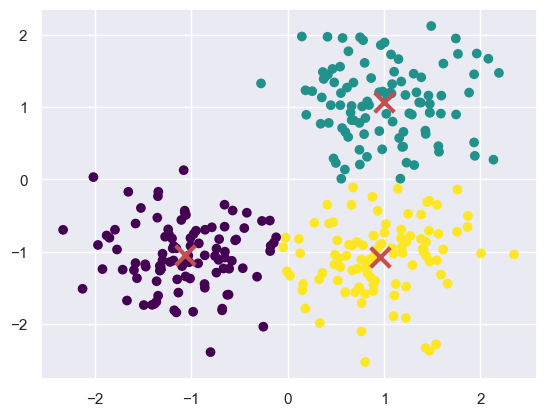

In [3]:
# Generate some sample data
np.random.seed(0)
X = np.vstack((np.random.randn(100, 2) * 0.5 + [1, 1],
               np.random.randn(100, 2) * 0.5 + [-1, -1],
               np.random.randn(100, 2) * 0.5 + [1, -1]))

# Perform K-means clustering
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(X)

# Plot the results
plt.scatter(X[:, 0], X[:, 1], c=kmeans.labels_, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='x', s=200, linewidths=3, color='r')
plt.show()


The *k*-means clustering model is simple and relatively easy to understand, but its simplicity leads to practical challenges in its application.

In particular, the non-probabilistic nature of *k*-means and its use of simple distance-from-cluster-center to assign cluster membership leads to poor performance for many real-world situations.

In this section we will take a look at Gaussian mixture models (GMMs), which can be viewed as an extension of the ideas behind *k*-means, but can also be a powerful tool for estimation beyond simple clustering.

## Motivating GMM: Weaknesses of k-Means

___

Let's take a look at some of the weaknesses of *k*-means and think about how we might improve the cluster model.

>It requires the user to specify the number of clusters (K) in advance, which may not always be known beforehand.

>The algorithm may be sensitive to the initial choice of cluster centroids and may converge to a suboptimal solution.

>It assumes that clusters are spherical and equally sized, which may not always be the case in real-world data.

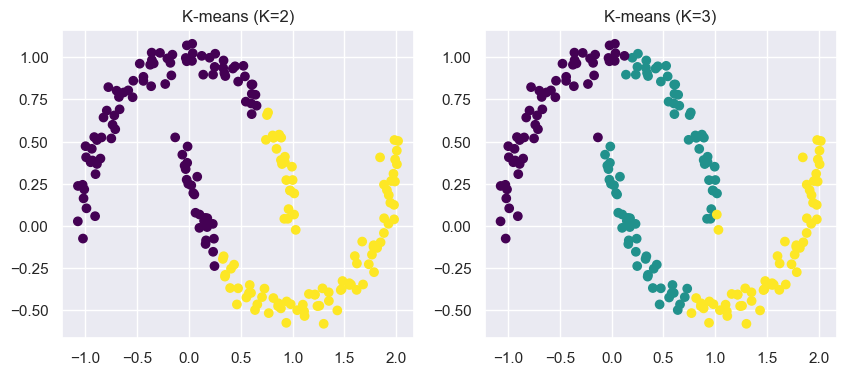

In [4]:
from sklearn.datasets import make_moons

# Generate sample data with two moon-shaped clusters
X, y = make_moons(n_samples=200, noise=0.05, random_state=0)

# Apply K-means clustering with two and three clusters
kmeans_2 = KMeans(n_clusters=2, random_state=0)
kmeans_2.fit(X)
kmeans_3 = KMeans(n_clusters=3, random_state=0)
kmeans_3.fit(X)

# Plot the results
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].scatter(X[:, 0], X[:, 1], c=kmeans_2.labels_, cmap='viridis')
ax[0].set_title('K-means (K=2)')
ax[1].scatter(X[:, 0], X[:, 1], c=kmeans_3.labels_, cmap='viridis')
ax[1].set_title('K-means (K=3)')
plt.show()

In this example, we generate a sample dataset with two moon-shaped clusters using the make_moons function from scikit-learn. We then apply the K-means algorithm with two and three clusters using the KMeans function from scikit-learn. Finally, we plot the results, showing that the K-means algorithm with three clusters produces suboptimal results, splitting one of the moon-shaped clusters into two separate clusters.

This example highlights the weakness of K-means in requiring the number of clusters to be specified in advance and its sensitivity to the initial choice of cluster centroids.

In [5]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

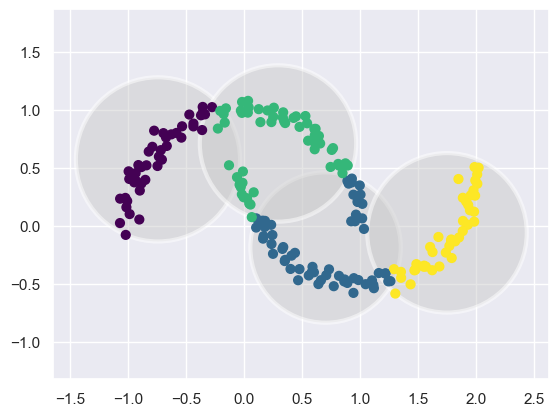

In [6]:
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

An important observation for *k*-means is that these cluster models *must be circular*: *k*-means has no built-in way of accounting for oblong or elliptical clusters.
So, for example, if we take the same data and transform it, the cluster assignments end up becoming muddled:

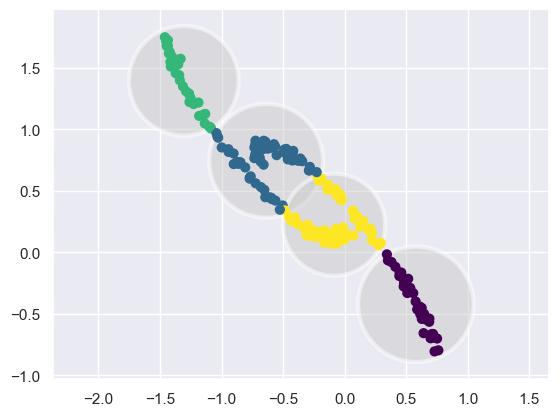

In [7]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

By eye, we recognize that these transformed clusters are non-circular, and thus circular clusters would be a poor fit.
Nevertheless, *k*-means is not flexible enough to account for this, and tries to force-fit the data into four circular clusters.
This results in a mixing of cluster assignments where the resulting circles overlap.
One might imagine addressing this particular situation by preprocessing the data with Principal Component Analysis, but in practice there is no guarantee that such a global operation will circularize the individual data.

    These two disadvantages of *k*-means—its lack of flexibility in cluster shape and lack of probabilistic cluster assignment—mean that for many datasets (especially low-dimensional datasets) it may not perform as well as you might hope.

    You might imagine addressing these weaknesses by generalizing the *k*-means model: for example, you could measure uncertainty in cluster assignment by comparing the distances of each point to *all* cluster centers, rather than focusing on just the closest.
    
    You might also imagine allowing the cluster boundaries to be ellipses rather than circles, so as to account for non-circular clusters.
    
    It turns out these are two essential components of a different type of clustering model, Gaussian mixture models.

## Generalizing E–M: Gaussian Mixture Models
___

Gaussian Mixture Models (GMM) is a generalization of the E-M algorithm for clustering and density estimation. It is a probabilistic model that assumes that the data is generated from a mixture of Gaussian distributions. Each Gaussian distribution in the mixture represents a cluster in the data, and the weights of the Gaussians represent the probabilities of belonging to each cluster. The goal of GMM is to estimate the parameters of the Gaussian mixture distribution from the data, including the means, covariances, and weights of each Gaussian.

>The GMM algorithm is an iterative procedure that alternates between two steps: the E-step and the M-step. In the E-step, the algorithm computes the probabilities of each data point belonging to each Gaussian component in the mixture, based on the current estimates of the Gaussian parameters. In the M-step, the algorithm updates the estimates of the Gaussian parameters based on the current probabilities of the data points belonging to each component. The algorithm iterates between these two steps until convergence, where the parameters no longer change significantly.

One advantage of GMM over K-means is that it allows for probabilistic cluster assignment, where each data point can be assigned a probability of belonging to each cluster, rather than a hard assignment. This can be useful in cases where the data is not well separated, or where a data point could belong to multiple clusters.

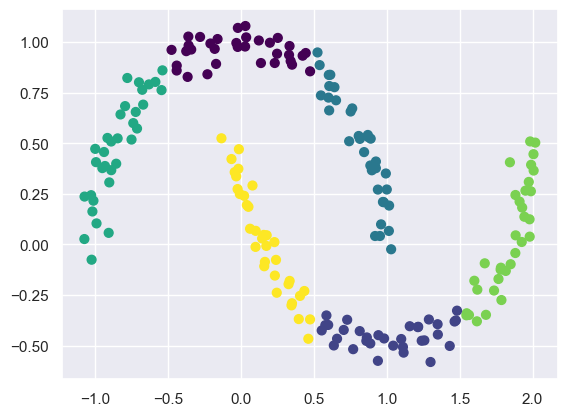

In [8]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=6).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

But because GMM contains a probabilistic model under the hood, it is also possible to find probabilistic cluster assignments—in Scikit-Learn this is done using the ``predict_proba`` method.
This returns a matrix of size ``[n_samples, n_clusters]`` which measures the probability that any point belongs to the given cluster:

In [9]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.    0.    1.    0.    0.    0.   ]
 [0.    0.326 0.    0.    0.674 0.   ]
 [0.    0.    0.    0.    0.    1.   ]
 [0.    0.    0.    1.    0.    0.   ]
 [0.    0.    0.    0.    1.    0.   ]]


We can visualize this uncertainty by, for example, making the size of each point proportional to the certainty of its prediction; looking at the following figure, we can see that it is precisely the points at the boundaries between clusters that reflect this uncertainty of cluster assignment:

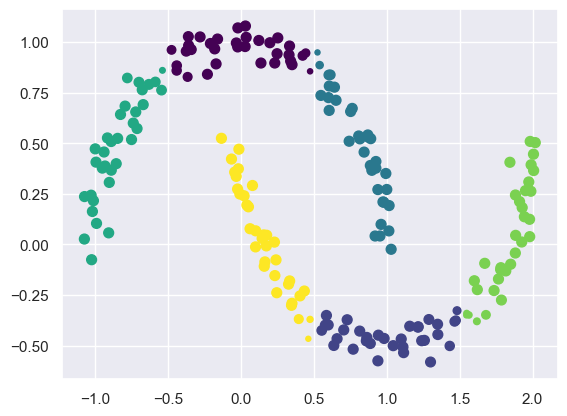

In [10]:
size = 50 * probs.max(1) ** 2  # square emphasizes differences
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size);

Under the hood, a Gaussian mixture model is very similar to *k*-means: it uses an expectation–maximization approach which qualitatively does the following:

1. Choose starting guesses for the location and shape

2. Repeat until converged:

   1. *E-step*: for each point, find weights encoding the probability of membership in each cluster
   2. *M-step*: for each cluster, update its location, normalization, and shape based on *all* data points, making use of the weights

The result of this is that each cluster is associated not with a hard-edged sphere, but with a smooth Gaussian model.
Just as in the *k*-means expectation–maximization approach, this algorithm can sometimes miss the globally optimal solution, and thus in practice multiple random initializations are used.

Let's create a function that will help us visualize the locations and shapes of the GMM clusters by drawing ellipses based on the GMM output:

In [11]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

With this in place, we can take a look at what the four-component GMM gives us for our initial data:

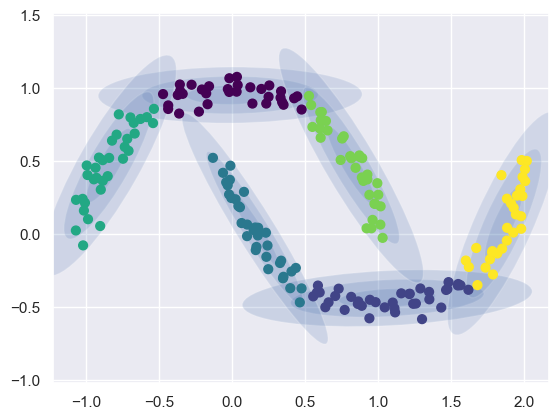

In [12]:
gmm = GaussianMixture(n_components=6, random_state=42)
gmm.fit(X)
plot_gmm(gmm, X)

Similarly, we can use the GMM approach to fit our stretched dataset; allowing for a full covariance the model will fit even very oblong, stretched-out clusters:

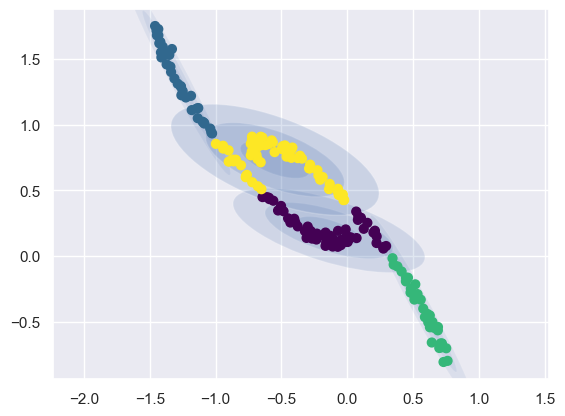

In [13]:
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched)

This makes clear that GMM addresses the two main practical issues with *k*-means encountered before.

### Choosing the covariance type

If you look at the details of the preceding fits, you will see that the ``covariance_type`` option was set differently within each.
This hyperparameter controls the degrees of freedom in the shape of each cluster; it is essential to set this carefully for any given problem.
The default is ``covariance_type="diag"``, which means that the size of the cluster along each dimension can be set independently, with the resulting ellipse constrained to align with the axes.
A slightly simpler and faster model is ``covariance_type="spherical"``, which constrains the shape of the cluster such that all dimensions are equal. The resulting clustering will have similar characteristics to that of *k*-means, though it is not entirely equivalent.
A more complicated and computationally expensive model (especially as the number of dimensions grows) is to use ``covariance_type="full"``, which allows each cluster to be modeled as an ellipse with arbitrary orientation.

We can see a visual representation of these three choices for a single cluster within the following figure:

## GMM as *Density Estimation*

___

Though GMM is often categorized as a clustering algorithm, fundamentally it is an algorithm for *density estimation*.
That is to say, the result of a GMM fit to some data is technically not a clustering model, but a generative probabilistic model describing the distribution of the data.

As an example, consider some data generated from Scikit-Learn's ``make_moons`` function, which we saw in [In Depth: K-Means Clustering](05.11-K-Means.ipynb):

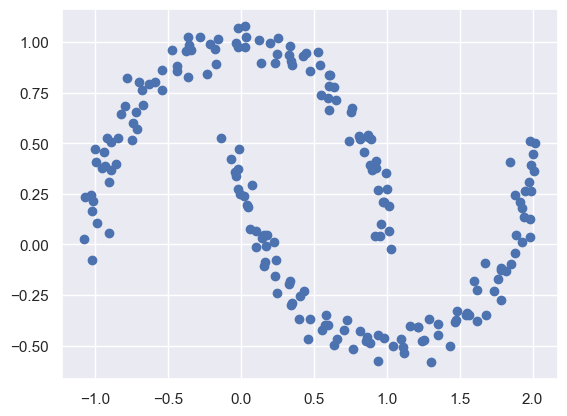

In [14]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

If we try to fit this with a two-component GMM viewed as a clustering model, the results are not particularly useful:

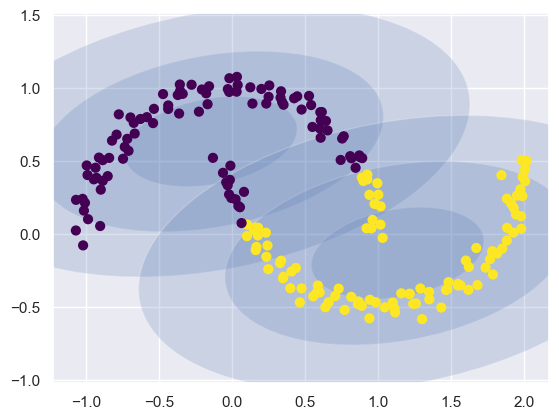

In [15]:
gmm2 = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, Xmoon)

But if we instead use many more components and ignore the cluster labels, we find a fit that is much closer to the input data:

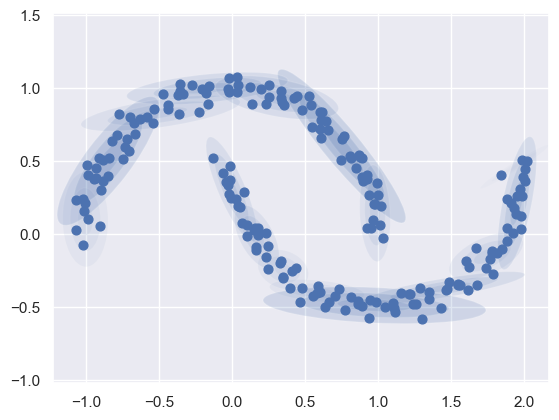

In [16]:
gmm16 = GaussianMixture(n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm16, Xmoon, label=False)

Here the mixture of 16 Gaussians serves not to find separated clusters of data, but rather to model the overall *distribution* of the input data.
This is a generative model of the distribution, meaning that the GMM gives us the recipe to generate new random data distributed similarly to our input.
For example, here are 800 new points drawn from this 16-component GMM fit to our original data:

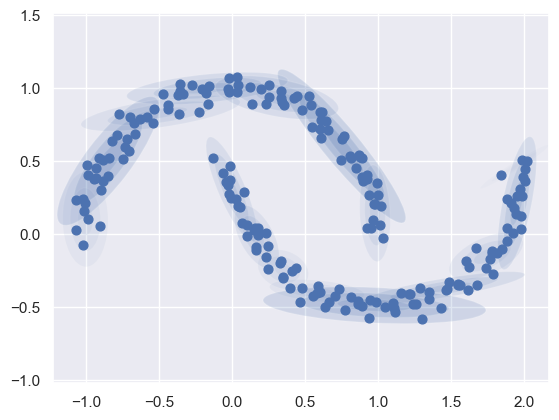

In [17]:
Xnew = gmm16.sample(800)
plot_gmm(gmm16, Xmoon, label=False)

GMM is convenient as a flexible means of modeling an arbitrary multi-dimensional distribution of data.

### How many components?

The fact that GMM is a generative model gives us a natural means of determining the optimal number of components for a given dataset.
A generative model is inherently a probability distribution for the dataset, and so we can simply evaluate the *likelihood* of the data under the model, using cross-validation to avoid over-fitting.
Another means of correcting for over-fitting is to adjust the model likelihoods using some analytic criterion such as the [Akaike information criterion (AIC)](https://en.wikipedia.org/wiki/Akaike_information_criterion) or the [Bayesian information criterion (BIC)](https://en.wikipedia.org/wiki/Bayesian_information_criterion).
Scikit-Learn's ``GMM`` estimator actually includes built-in methods that compute both of these, and so it is very easy to operate on this approach.

Let's look at the AIC and BIC as a function as the number of GMM components for our moon dataset:

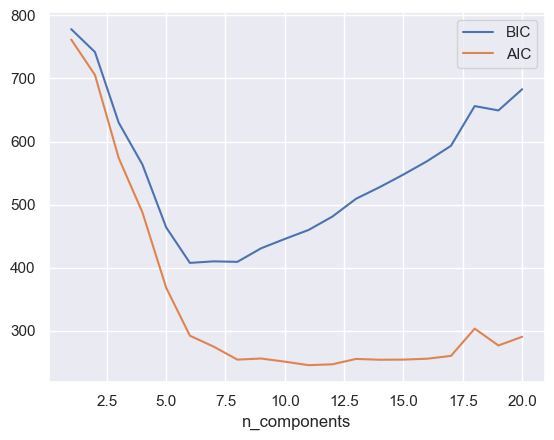

In [18]:
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(Xmoon)
          for n in n_components]

plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

The optimal number of clusters is the value that minimizes the AIC or BIC, depending on which approximation we wish to use. The AIC tells us that our choice of 16 components above was probably too many: around 8-12 components would have been a better choice.
As is typical with this sort of problem, the BIC recommends a simpler model.

Notice the important point: this choice of number of components measures how well GMM works *as a density estimator*, not how well it works *as a clustering algorithm*.
I'd encourage you to think of GMM primarily as a density estimator, and use it for clustering only when warranted within simple datasets.

## Example: GMM for Generating New Data

We just saw a simple example of using GMM as a generative model of data in order to create new samples from the distribution defined by the input data.
Here we will run with this idea and generate *new handwritten digits* from the standard digits corpus that we have used before.

To start with, let's load the digits data using Scikit-Learn's data tools:

In [19]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

Next let's plot the first 100 of these to recall exactly what we're looking at:

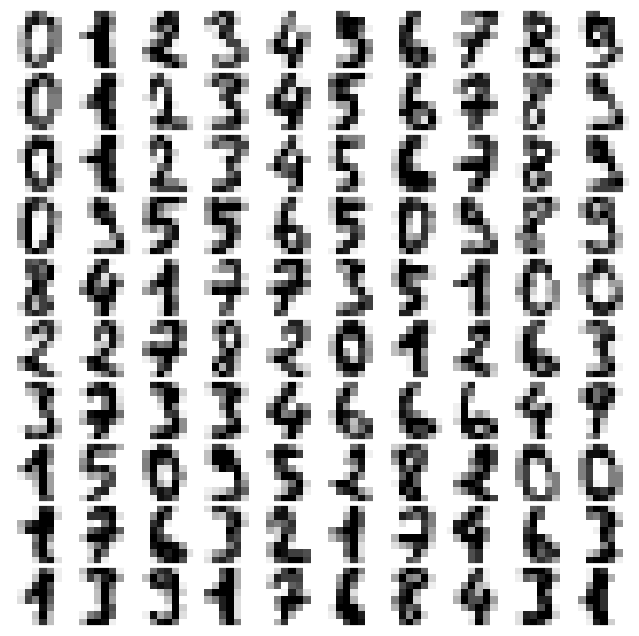

In [20]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

We have nearly 1,800 digits in 64 dimensions, and we can build a GMM on top of these to generate more.